# EECS 491: Probabilistic Graphical Models Assignment 4
**David Fan**

4/11/18

# Exercise 4

In this notebook we will combine the work we have done in the previous exercises to train a Gaussian Mixture Model on the MNIST dataset that has been reduced to two dimensions.

We begin as always by importing the necessary Python packages and importing the needed functions from the previous exercises:

In [3]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2
from sklearn.decomposition import PCA

%matplotlib inline

In [8]:
def covmatIsLegal(sigma):
    legal = True
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            legal = False
    print("Convariance Matrices are Legal? : %r" % legal)

In [9]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

In [10]:
def expectation(data, gmmcp):
    rows,dims = data.shape
    cols = len(gmmcp)
    posterior = np.zeros((rows,cols))
    for row in range(rows):
        for col in range(cols):
            gmm = gmmcp[col]
            mean = gmm['mean']
            covariance = gmm['covariance']
            prior = gmm['prior']
            num = multivariate_gaussian(dims, mean, covariance, data[row]) * prior
            denom = 0
            for j in range(cols):
                gmm = gmmcp[j]
                mean = gmm['mean']
                covariance = gmm['covariance']
                prior = gmm['prior']
                g = multivariate_gaussian(dims, mean, covariance, data[row])
                denom += g * prior
            posterior[row, col] = num/denom
    return posterior

In [11]:
def multivariate_gaussian(dims, mean, covariance, example):
    A = 1/((2*np.pi)**(dims/2)*np.linalg.det(covariance)**.5)
    B = np.exp(-.5*(example - mean).T.dot(np.linalg.inv(covariance).dot((example - mean))))
    return A * B

In [12]:
def maximization(posterior, data, gmmcp):
    update_gmm = gmmcp
    rows, cols = posterior.shape
    pk = np.zeros(cols)
    for col in range(cols):
        for row in range(rows):
            pk[col] += posterior[row, col]
    for col in range(cols):
        gmm = update_gmm[col]
        # Update the mean
        mean = 0
        for row in range(rows):
            mean += posterior[row,col]*(data[row])/pk[col]
        # Update the covariance
        covariance = 0
        for row in range(rows):
            x = (data[row]-gmm['mean'])[:,None]
            covariance += posterior[row,col]*x.dot(x.T)/pk[col]
        gmm['mean'] = mean
        gmm['covariance'] = covariance
        gmm['prior'] = pk[col]/rows

    return gmmcp

In [13]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    f = pickle._Unpickler(f)
    f.encoding = 'latin1'
    trainSet, validSet, testSet = f.load()
    mnistData = np.concatenate((trainSet[0], validSet[0], testSet[0]), axis=0)

In [14]:
def dimReducePCA(data, dims):
    pca = PCA(n_components=dims)
    reduced_data = pca.fit_transform(data)
    pca = PCA()
    pca.fit(data)
    eigen_vectors = pca.components_.T
    eigen_values = pca.explained_variance_
    return reduced_data, eigen_vectors, eigen_values 

In [16]:
mnistData2D, eigenVectors, eigenValues = dimReducePCA(mnistData, 2)

We then create functions for randomly initializing a number of means and a number of covariance matrices. The following functions were taken from the demo:

In [17]:
# randomly pick coordinates as center of Gaussian distribution
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

In [18]:
def randinitCovariance(n):
    sigma = []
    for m in range(n):
        # randomly pick a direction
        angle = np.random.uniform(0, 2 * np.pi)
        # create eigen vector with the direction and direction orthogonal to it
        eigenVector = np.asarray([[np.cos(angle), np.sin(angle)],
                                  [np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)]])
        # randomly generate eigen values
        eigenValue = abs(np.random.normal(size=2))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    # return in form of numpy.ndarray
    return np.asarray(sigma)

We can now test the random covariance matrix generation function to ensure that it produces legal covariance matrices:

In [19]:
covmatIsLegal(randinitCovariance(10))

Convariance Matrices are Legal? : True


While our algorithm will work just fine on the entirety of the MNIST dataset, it will take a really long time so we'll train on a smaller sample of the dataset:

In [20]:
ndata = 1000
# randomly pick a subset of data
data = mnistData2D[np.random.randint(len(mnistData2D), size=ndata)]

Now let's initialize our Gaussian Mixture Model:

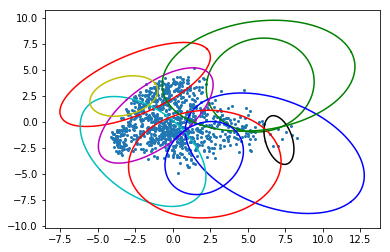

In [21]:
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovariance(ngmm)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

# show initial state
gmmplot(data, gmm)

Now let us train our GMM using our Expectation-Maximization algorithm:

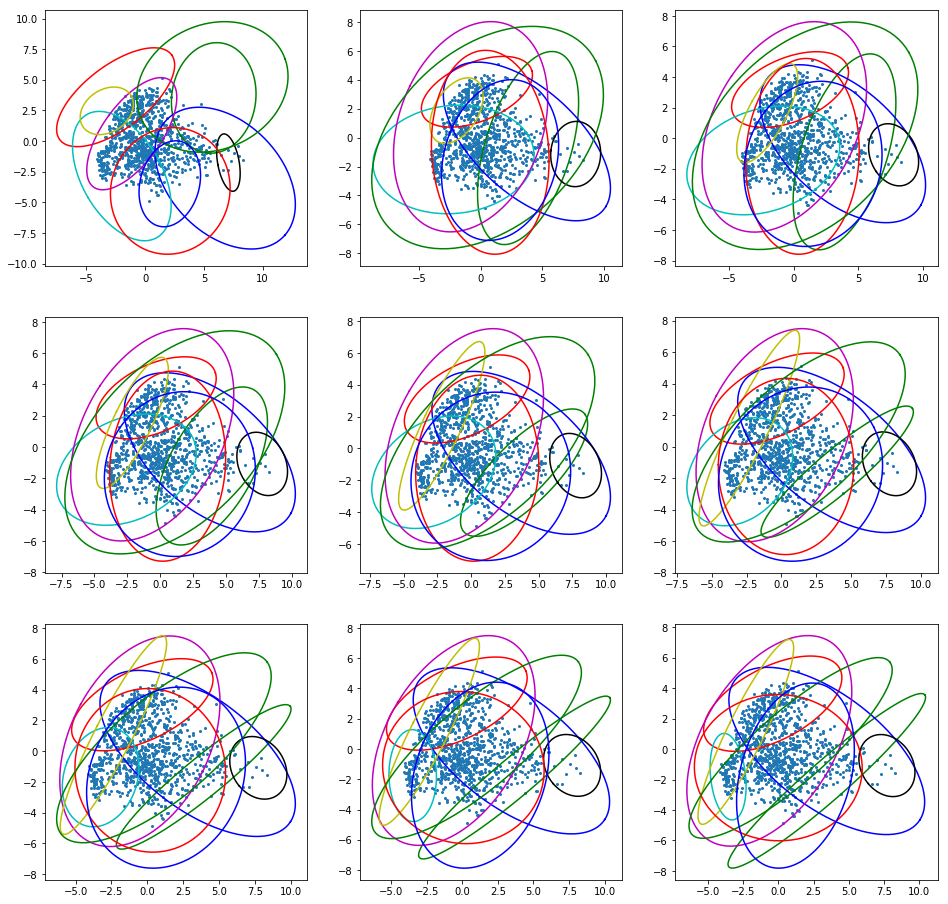

In [22]:
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 16))
# improve model with EM-Algorithm
for i in range(8):
    # plot current status
    plt.subplot(331 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(339)
gmmplot(data,gmmcp)